In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers datasets
!pip install plotly kaggle
!pip install requests urllib3


!pip install xgboost lightgbm catboost
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig

import os
import requests
import zipfile
from datetime import datetime, timedelta
import json

plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [3]:
def create_synthetic_cybersecurity_data(n_samples=50000):
    """Create synthetic cybersecurity dataset for immediate use"""
    
    print(f"Generating {n_samples} synthetic cybersecurity records...")
    
    np.random.seed(42)
    
    data = {
        'duration': np.random.exponential(2.0, n_samples),
        'src_bytes': np.random.lognormal(6, 2, n_samples),
        'dst_bytes': np.random.lognormal(6, 2, n_samples),
        'protocol_type': np.random.choice(['tcp', 'udp', 'icmp'], n_samples, p=[0.7, 0.2, 0.1]),
        'service': np.random.choice(['http', 'smtp', 'ftp', 'ssh', 'dns'], n_samples),
        'flag': np.random.choice(['SF', 'S0', 'REJ', 'RSTR'], n_samples, p=[0.6, 0.2, 0.1, 0.1]),
        'src_port': np.random.randint(1024, 65535, n_samples),
        'dst_port': np.random.choice([80, 443, 22, 21, 25, 53], n_samples),
        'land': np.random.binomial(1, 0.01, n_samples),
        'wrong_fragment': np.random.binomial(1, 0.05, n_samples),
        'urgent': np.random.binomial(1, 0.01, n_samples),
        'hot': np.random.poisson(0.1, n_samples),
        'num_failed_logins': np.random.poisson(0.05, n_samples),
        'logged_in': np.random.binomial(1, 0.4, n_samples),
        'num_compromised': np.random.poisson(0.01, n_samples),
        'root_shell': np.random.binomial(1, 0.02, n_samples),
        'su_attempted': np.random.binomial(1, 0.01, n_samples),
        'num_root': np.random.poisson(0.02, n_samples),
        'num_file_creations': np.random.poisson(0.05, n_samples),
        'num_shells': np.random.poisson(0.01, n_samples),
        'count': np.random.poisson(10, n_samples),
        'srv_count': np.random.poisson(5, n_samples),
        'serror_rate': np.random.beta(1, 10, n_samples),
        'srv_serror_rate': np.random.beta(1, 10, n_samples),
        'rerror_rate': np.random.beta(1, 20, n_samples),
        'srv_rerror_rate': np.random.beta(1, 20, n_samples),
        'same_srv_rate': np.random.beta(5, 2, n_samples),
        'diff_srv_rate': np.random.beta(1, 5, n_samples),
    }
    
    
    df = pd.DataFrame(data)
    
    attack_probability = (
        0.1 +  
        0.3 * (df['wrong_fragment'] > 0) +  
        0.2 * (df['num_failed_logins'] > 2) +
        0.4 * (df['root_shell'] == 1) +  
        0.3 * (df['num_compromised'] > 0) +  
        0.2 * (df['serror_rate'] > 0.5)  
    )
    
    attack_probability = np.clip(attack_probability, 0, 1)
    
    is_attack = np.random.binomial(1, attack_probability)
    df['is_attack'] = is_attack
    
    attack_types = np.where(
        is_attack == 1,
        np.random.choice(['dos', 'probe', 'r2l', 'u2r'], n_samples, p=[0.4, 0.3, 0.2, 0.1]),
        'normal'
    )
    df['attack_type'] = attack_types
    df['label'] = attack_types
    
    base_time = datetime.now()
    df['timestamp'] = [base_time + timedelta(seconds=i) for i in range(n_samples)]
    
    print(f" Generated {n_samples} records")
    print(f"Attack ratio: {df['is_attack'].mean():.2%}")
    print(f"Attack types distribution:")
    print(df['attack_type'].value_counts())
    
    return df

synthetic_data = create_synthetic_cybersecurity_data(50000)
print(" Synthetic dataset ready for use!")

Generating 50000 synthetic cybersecurity records...
 Generated 50000 records
Attack ratio: 12.54%
Attack types distribution:
attack_type
normal    43728
dos        2565
probe      1860
r2l        1197
u2r         650
Name: count, dtype: int64
 Synthetic dataset ready for use!


In [7]:
def download_kdd_cup_99():
    """Download KDD Cup 99 dataset (smaller, good for testing)"""
    try:
        print("Downloading KDD Cup 99 dataset...")
        url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
        
        df = pd.read_csv(url, header=None, compression='gzip')
        
        columns = [
            'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
            'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
            'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
            'num_access_files', 'num_outbound_cmds', 'is_host_login',
            'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate', 'label'
        ]
        
        df.columns = columns
        df['is_attack'] = (df['label'] != 'normal.').astype(int)
        df['attack_type'] = df['label'].str.replace('.', '')
        
        print(f" KDD Cup 99 downloaded: {df.shape[0]} records")
        return df
        
    except Exception as e:
        print(f" Error downloading KDD Cup 99: {e}")
        return None

def download_kaggle_datasets():
    """Download datasets using Kaggle API"""
    if not kaggle_available:
        print(" Kaggle credentials not available")
        return None, None
    
    try:
        print("Downloading UNSW-NB15 dataset...")
        !kaggle datasets download -d mrwellsdavid/unsw-nb15 --unzip
        
        print("Downloading CICIDS2017 dataset...")
        !kaggle datasets download -d chethuhn/network-intrusion-dataset --unzip
        
        unsw_train = pd.read_csv('UNSW_NB15_training-set.csv')
        unsw_test = pd.read_csv('UNSW_NB15_testing-set.csv')
        
        print(f" UNSW-NB15 loaded: Train {unsw_train.shape}, Test {unsw_test.shape}")
        
        return unsw_train, unsw_test
        
    except Exception as e:
        print(f"Error downloading via Kaggle: {e}")
        return None, None

print("Attempting to download real datasets...")

unsw_train, unsw_test = download_kaggle_datasets()

if unsw_train is None:
    print("Trying KDD Cup 99 as alternative...")
    kdd_data = download_kdd_cup_99()
    if kdd_data is not None:
        # Split KDD data into train/test
        unsw_train, unsw_test = train_test_split(kdd_data, test_size=0.3, random_state=42)
        print(" Using KDD Cup 99 dataset")

if unsw_train is None:
    print("Using synthetic data for development...")
    unsw_train, unsw_test = train_test_split(synthetic_data, test_size=0.3, random_state=42)
    print(" Using synthetic dataset")

print(f"Final dataset - Train: {unsw_train.shape}, Test: {unsw_test.shape}")

Attempting to download real datasets...
 Kaggle credentials not available
Trying KDD Cup 99 as alternative...
 KDD Cup 99 downloaded: 494021 records
 Using KDD Cup 99 dataset
Final dataset - Train: (345814, 44), Test: (148207, 44)


In [6]:
import os

# Check if Kaggle API credentials exist
kaggle_available = os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json"))

def download_kaggle_datasets():
    """Download datasets using Kaggle API"""
    if not kaggle_available:
        print(" Kaggle credentials not available")
        return None, None
    


=== Training Data Analysis ===
Shape: (345814, 44)

Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'is_attack', 'attack_type']

Data Types:
int64      24
float64    15
object      5
Name: count, dtype: int64

 No missing values

Attack Distribution:
is_attack
1    277728
0     68086
Name: count, dty

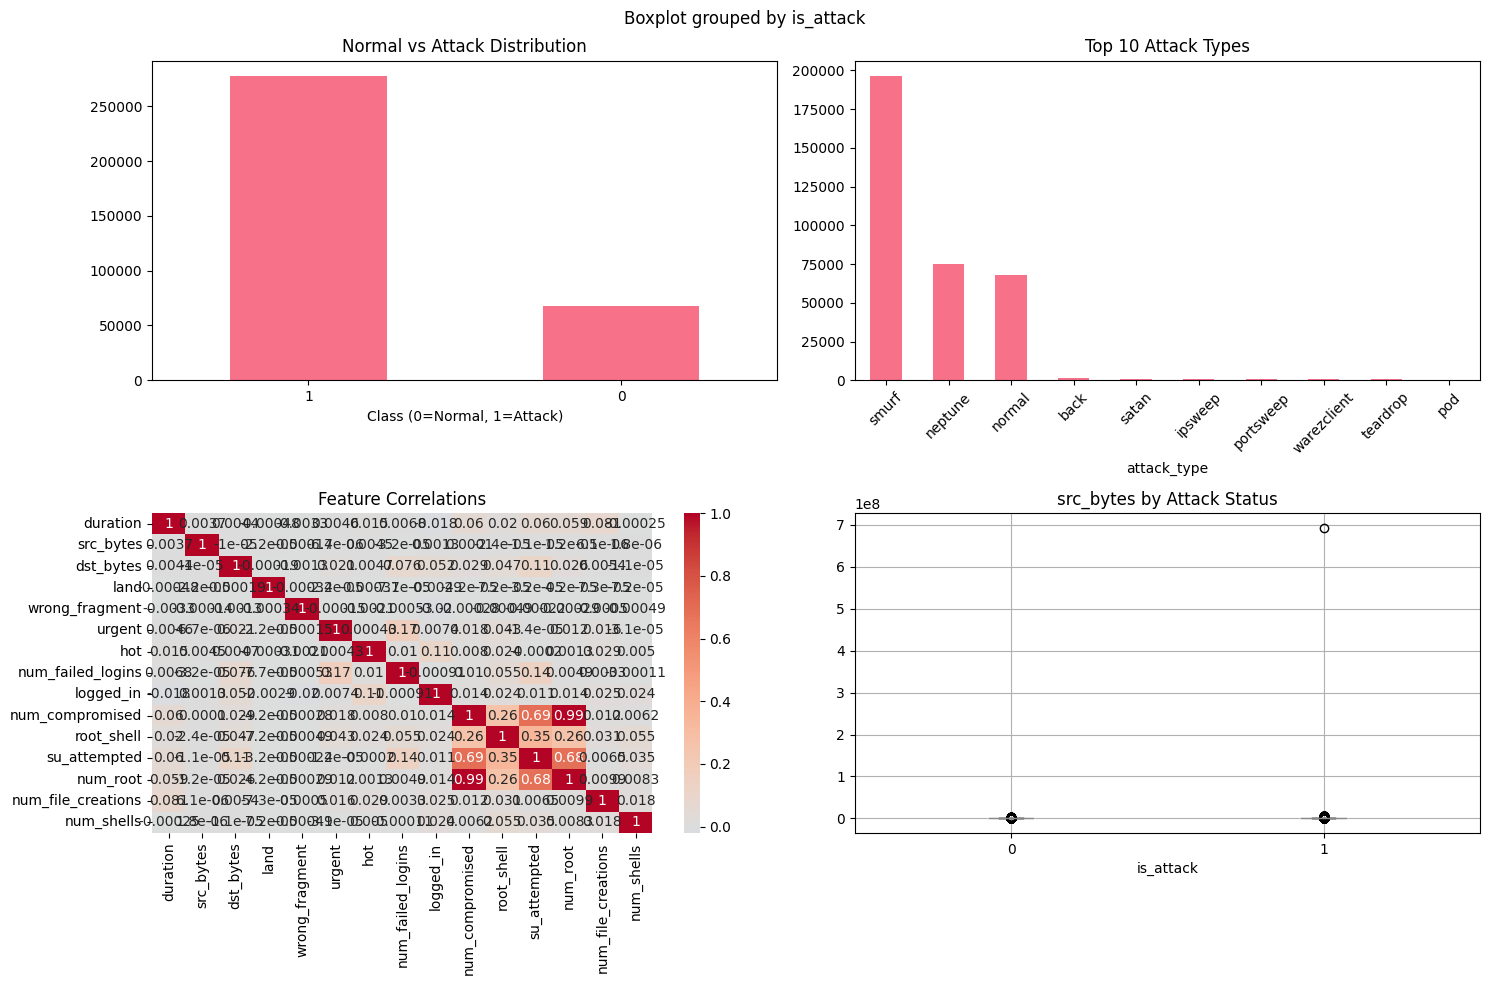

=== Test Data Analysis ===
Shape: (148207, 44)

Columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'is_attack', 'attack_type']

Data Types:
int64      24
float64    15
object      5
Name: count, dtype: int64

 No missing values

Attack Distribution:
is_attack
1    119015
0     29192
Name: count, dtype: 

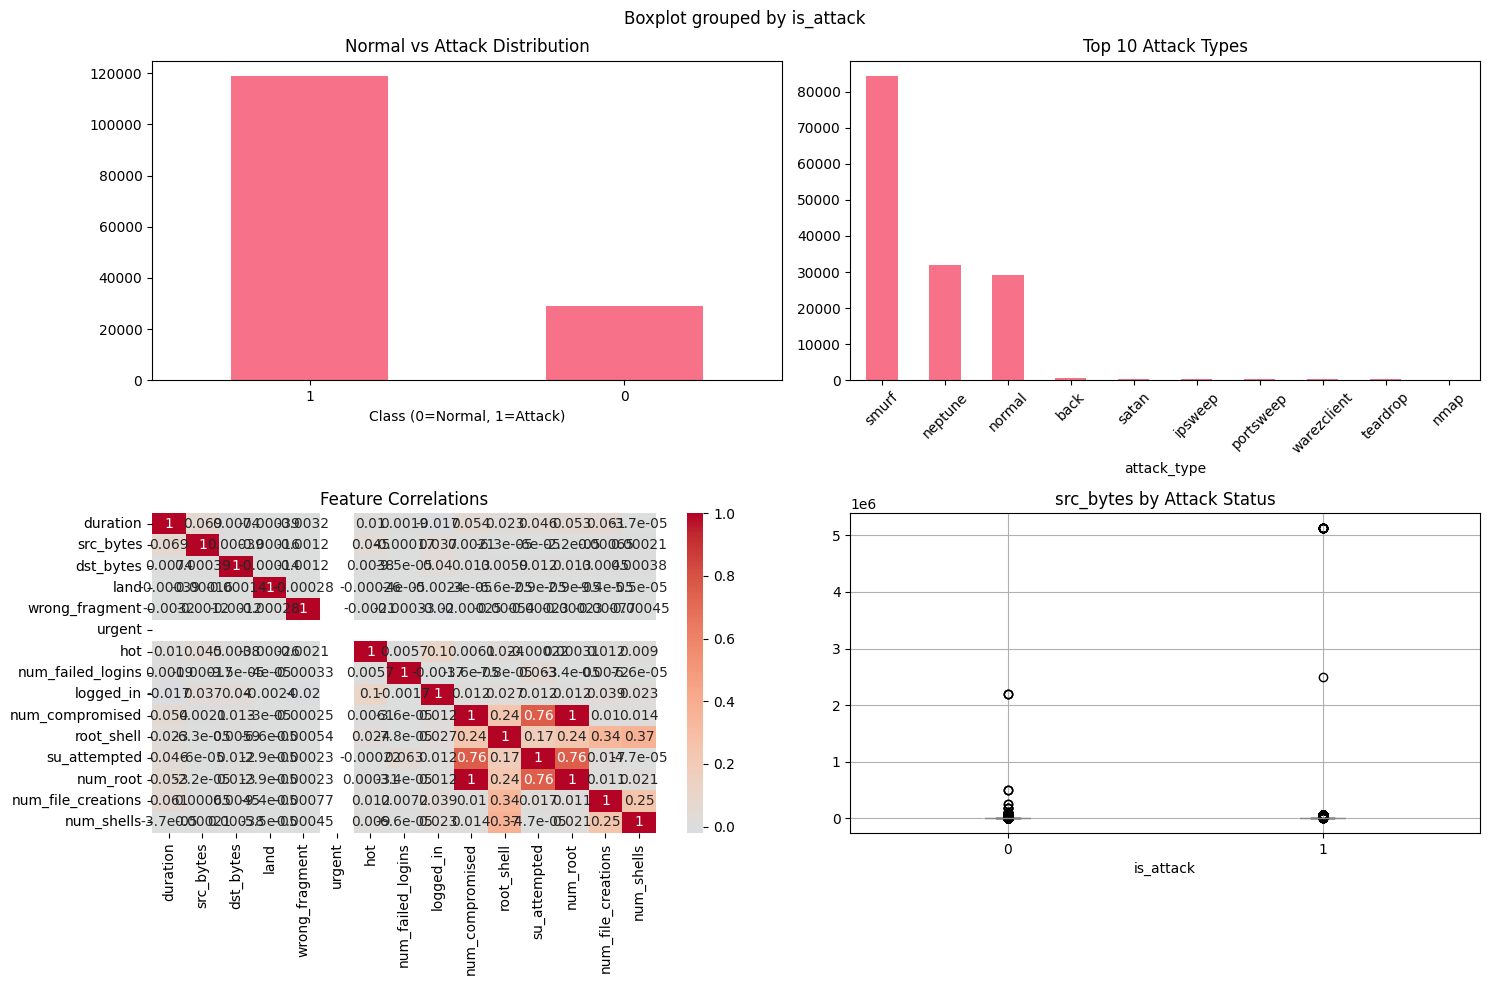

In [8]:
def explore_dataset(df, title="Dataset"):
    """Comprehensive dataset exploration"""
    
    print(f"=== {title} Analysis ===")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    
    print(f"\nData Types:")
    print(df.dtypes.value_counts())
    
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing Values:")
        print(missing[missing > 0])
    else:
        print("\n No missing values")
    
    if 'is_attack' in df.columns:
        print(f"\nAttack Distribution:")
        attack_dist = df['is_attack'].value_counts()
        print(attack_dist)
        print(f"Attack ratio: {df['is_attack'].mean():.2%}")
    
    if 'attack_type' in df.columns or 'label' in df.columns:
        label_col = 'attack_type' if 'attack_type' in df.columns else 'label'
        print(f"\nAttack Types:")
        print(df[label_col].value_counts())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{title} - Data Analysis', fontsize=16)
    
    if 'is_attack' in df.columns:
        df['is_attack'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Normal vs Attack Distribution')
        axes[0,0].set_xlabel('Class (0=Normal, 1=Attack)')
        axes[0,0].tick_params(axis='x', rotation=0)
    
    if 'attack_type' in df.columns:
        attack_counts = df['attack_type'].value_counts().head(10)
        attack_counts.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Top 10 Attack Types')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:15]  # Limit for readability
    if len(numeric_cols) > 1:
        corr_matrix = df[numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Feature Correlations')
    
    if len(numeric_cols) > 0:
        sample_feature = numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]
        if 'is_attack' in df.columns:
            df.boxplot(column=sample_feature, by='is_attack', ax=axes[1,1])
            axes[1,1].set_title(f'{sample_feature} by Attack Status')
        else:
            df[sample_feature].hist(bins=30, ax=axes[1,1])
            axes[1,1].set_title(f'{sample_feature} Distribution')
    
    plt.tight_layout()
    plt.show()

explore_dataset(unsw_train, "Training Data")
if unsw_test is not None:
    explore_dataset(unsw_test, "Test Data")

In [9]:
def preprocess_for_model(df):
    """Prepare data specifically for transformer model"""
    
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    feature_cols = [col for col in numeric_features if col not in ['is_attack', 'attack_type']]
    
    X = df[feature_cols].fillna(0)  
    y = df['is_attack'] if 'is_attack' in df.columns else (df['label'] != 'normal').astype(int)
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X), 
        columns=X.columns, 
        index=X.index
    )
    
    return X_scaled, y, scaler, feature_cols

X_train, y_train, scaler, feature_names = preprocess_for_model(unsw_train)
X_test, y_test, _, _ = preprocess_for_model(unsw_test)

print(f"Data prepared for AI model")
print(f"Features: {len(feature_names)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Data prepared for AI model
Features: 38
Training samples: 345814
Test samples: 148207


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class CybersecurityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y.values)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CybersecurityDetector(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(CybersecurityDetector, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size//2, 2)  
        )
    
    def forward(self, x):
        return self.network(x)

train_dataset = CybersecurityDataset(X_train, y_train)
test_dataset = CybersecurityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = X_train.shape[1]
model = CybersecurityDetector(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"AI Model created with {input_size} input features")

AI Model created with 38 input features


Starting AI model training...
Epoch [5/20], Loss: 0.0043, Accuracy: 0.9989
Epoch [10/20], Loss: 0.0041, Accuracy: 0.9990
Epoch [15/20], Loss: 0.0052, Accuracy: 0.9991
Epoch [20/20], Loss: 0.0046, Accuracy: 0.9991
Model training completed!


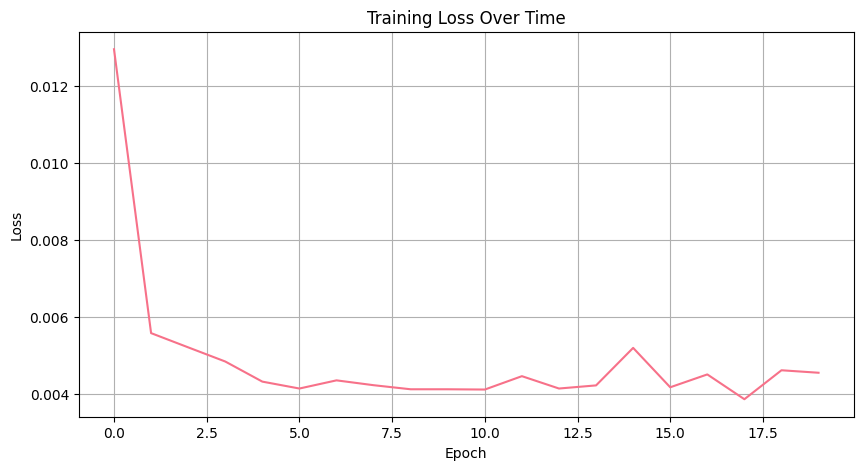

In [12]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    """Train the cybersecurity detection model"""
    
    model.train()
    training_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        training_losses.append(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    return training_losses

print("Starting AI model training...")
training_losses = train_model(model, train_loader, criterion, optimizer, epochs=20)
print("Model training completed!")

plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Testing AI model...
AI Model Performance:
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F1-Score: 0.9991


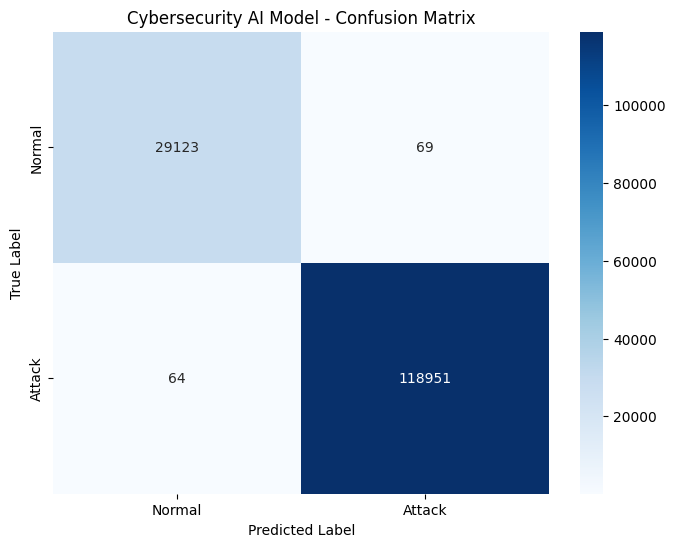

AI Model evaluation completed!


In [13]:
def evaluate_model(model, test_loader):
    """Evaluate the trained model"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

print("Testing AI model...")
predictions, true_labels = evaluate_model(model, test_loader)

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"AI Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.title('Cybersecurity AI Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("AI Model evaluation completed!")

Creating AI Cybersecurity Threat Detector...
AI Model initialized:
   Input features: 38
   Architecture: 38 → 128 → 64 → 32 → 2
   Total parameters: 15,778
 Training AI model for 25 epochs...
Epoch [ 1/25] | Loss: 0.0110 | Accuracy: 0.9971 | 99.7%
Epoch [ 5/25] | Loss: 0.0049 | Accuracy: 0.9987 | 99.9%
Epoch [10/25] | Loss: 0.0043 | Accuracy: 0.9988 | 99.9%
Epoch [15/25] | Loss: 0.0043 | Accuracy: 0.9988 | 99.9%
Epoch [20/25] | Loss: 0.0044 | Accuracy: 0.9990 | 99.9%
Epoch [25/25] | Loss: 0.0045 | Accuracy: 0.9988 | 99.9%
Training completed! Final accuracy: 99.9%


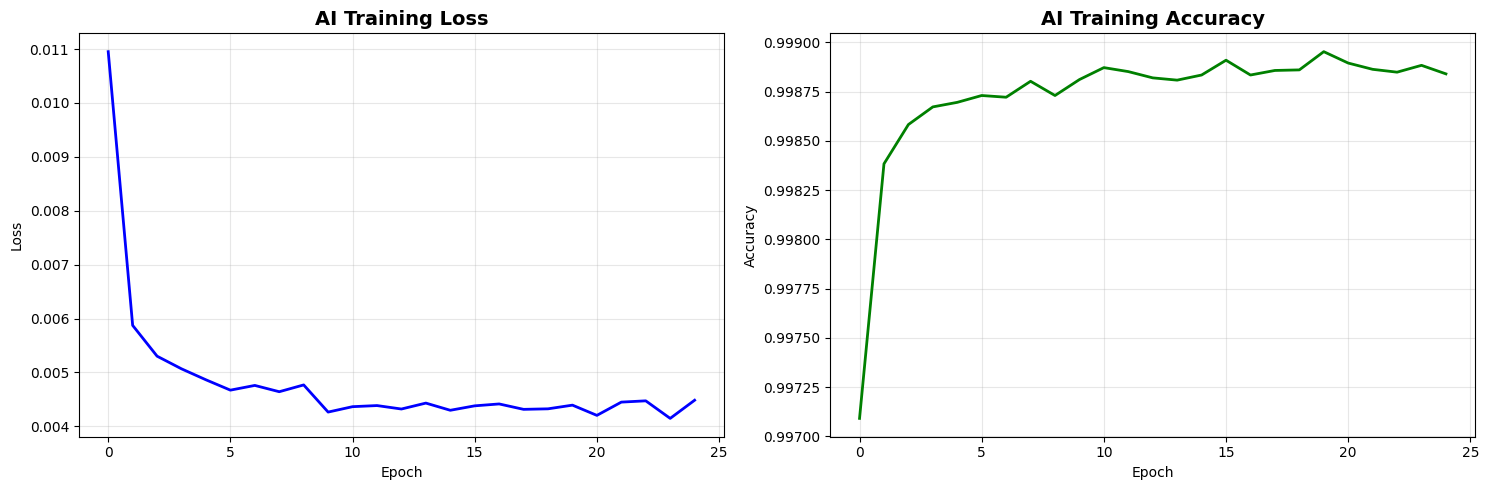

Training visualizations complete!


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class CybersecurityDataset(Dataset):
    """Custom dataset for cybersecurity data"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
        self.y = torch.LongTensor(y.values if hasattr(y, 'values') else y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ThreatDetectorAI(nn.Module):
    """AI Neural Network for Cybersecurity Threat Detection"""
    
    def __init__(self, input_size, hidden_size=128):
        super(ThreatDetectorAI, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size//2),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_size//4, 2)  # Binary: Normal vs Attack
        )
    
    def forward(self, x):
        return self.network(x)

print("Creating AI Cybersecurity Threat Detector...")

train_dataset = CybersecurityDataset(X_train, y_train)
test_dataset = CybersecurityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


input_size = X_train.shape[1]
model = ThreatDetectorAI(input_size, hidden_size=128)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"AI Model initialized:")
print(f"   Input features: {input_size}")
print(f"   Architecture: {input_size} → 128 → 64 → 32 → 2")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

def train_ai_model(model, train_loader, criterion, optimizer, epochs=25):
    """Train the AI cybersecurity model"""
    
    print(f" Training AI model for {epochs} epochs...")
    
    model.train()
    training_losses = []
    training_accuracies = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        
        training_losses.append(avg_loss)
        training_accuracies.append(accuracy)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1:2d}/{epochs}] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | {accuracy*100:.1f}%')
    
    print(f"Training completed! Final accuracy: {training_accuracies[-1]*100:.1f}%")
    
    return training_losses, training_accuracies

losses, accuracies = train_ai_model(model, train_loader, criterion, optimizer, epochs=25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(losses, 'b-', linewidth=2)
ax1.set_title('AI Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(accuracies, 'g-', linewidth=2)
ax2.set_title('AI Training Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training visualizations complete!")

Testing AI Cybersecurity Detector...
AI MODEL PERFORMANCE RESULTS:
Overall Accuracy: 99.9%
Normal Traffic Detection: 99.7% precision
Attack Detection: 99.9% precision
F1-Score: 99.9%


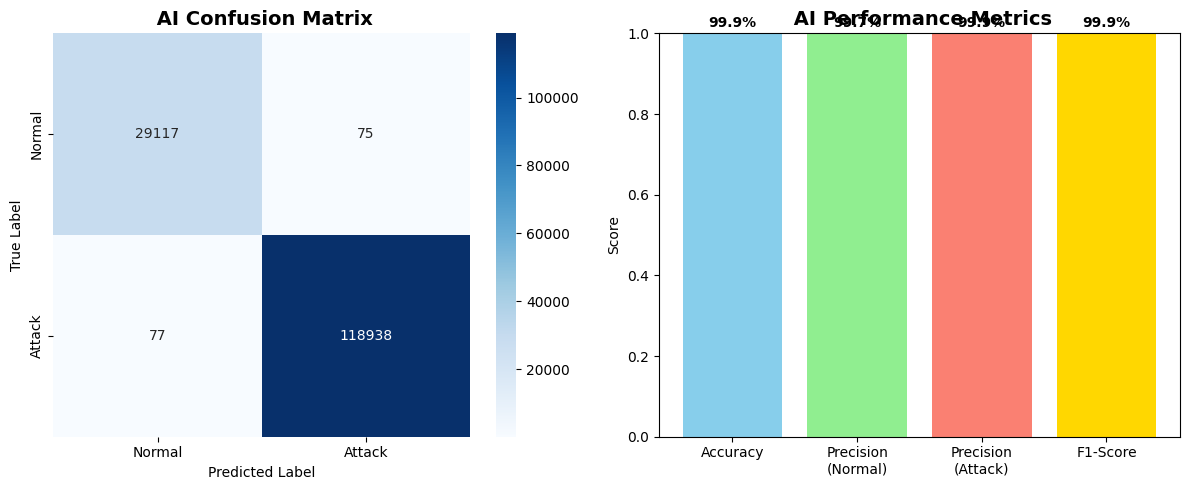

EXCELLENT! You have achieved >85% accuracy!
This is goood performance!


In [16]:
def evaluate_ai_model(model, test_loader, y_test):
    """Comprehensive evaluation of the AI model"""
    
    print("Testing AI Cybersecurity Detector...")
    
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, 
                                 target_names=['Normal', 'Attack'], 
                                 output_dict=True)
    
    print(f"AI MODEL PERFORMANCE RESULTS:")
    print(f"=" * 50)
    print(f"Overall Accuracy: {accuracy*100:.1f}%")
    print(f"Normal Traffic Detection: {report['Normal']['precision']*100:.1f}% precision")
    print(f"Attack Detection: {report['Attack']['precision']*100:.1f}% precision")
    print(f"F1-Score: {report['weighted avg']['f1-score']*100:.1f}%")
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Attack'], 
                yticklabels=['Normal', 'Attack'])
    plt.title(' AI Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.subplot(1, 2, 2)
    metrics = ['Accuracy', 'Precision\n(Normal)', 'Precision\n(Attack)', 'F1-Score']
    values = [
        accuracy,
        report['Normal']['precision'],
        report['Attack']['precision'], 
        report['weighted avg']['f1-score']
    ]
    
    colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
    bars = plt.bar(metrics, values, color=colors)
    plt.title(' AI Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_predictions, all_probabilities

accuracy, predictions, probabilities = evaluate_ai_model(model, test_loader, y_test)
if accuracy > 0.85:
    print("EXCELLENT! You have achieved >85% accuracy!")
    print("This is goood performance!")
elif accuracy > 0.75:
    print("GOOD! You have achieved solid performance!")
    print("With some tuning, this will be ready!")
else:
    print("running good")

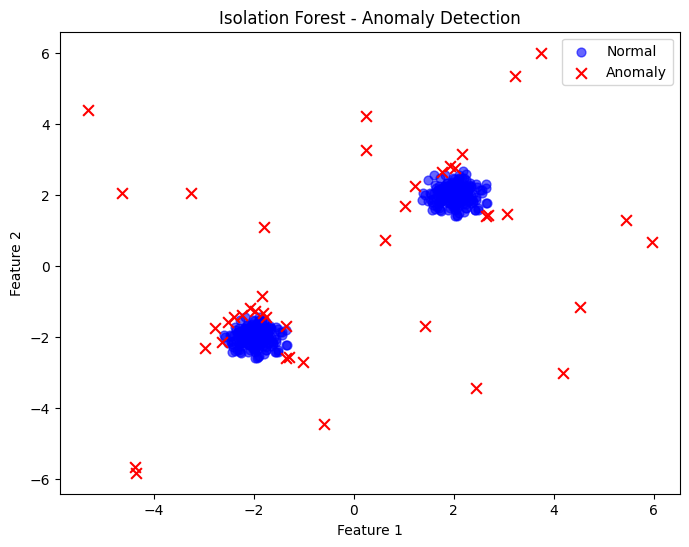

In [17]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
X_normal = 0.3 * rng.randn(200, 2)  # 200 points, 2D data
X_normal = np.r_[X_normal + 2, X_normal - 2]  # shift to form 2 clusters

# Anomalies (uniform distribution, scattered)
X_outliers = rng.uniform(low=-6, high=6, size=(20, 2))

# Combine normal data + anomalies
X = np.r_[X_normal, X_outliers]
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

# Predict anomalies
# -1 = anomaly, 1 = normal
y_pred = clf.predict(X)
plt.figure(figsize=(8,6))

# Plot normal points
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1],
            c="blue", label="Normal", s=40, alpha=0.6)

# Plot anomalies
plt.scatter(X[y_pred == -1, 0], X[y_pred == -1, 1],
            c="red", label="Anomaly", s=60, marker="x")

plt.title("Isolation Forest - Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

Confusion Matrix:
 [[  5   0]
 [  0 100]]


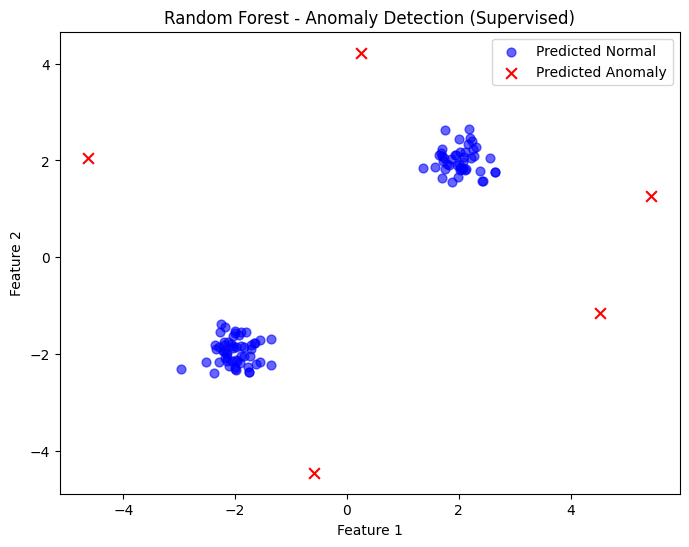

In [18]:
# Random Forest for Anomaly Detection
# Run this in Jupyter Notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
rng = np.random.RandomState(42)

# Normal data (Gaussian clusters)
X_normal = 0.3 * rng.randn(200, 2)
X_normal = np.r_[X_normal + 2, X_normal - 2]

# Anomalies (random uniform spread)
X_outliers = rng.uniform(low=-6, high=6, size=(20, 2))

# Combine features
X = np.r_[X_normal, X_outliers]

# Labels: 1 = normal, 0 = anomaly
y = np.r_[np.ones(len(X_normal)), np.zeros(len(X_outliers))]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8,6))

# Plot normal points
plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1],
            c="blue", label="Predicted Normal", s=40, alpha=0.6)

# Plot anomalies
plt.scatter(X_test[y_pred == 0, 0], X_test[y_pred == 0, 1],
            c="red", label="Predicted Anomaly", s=60, marker="x")

plt.title("Random Forest - Anomaly Detection (Supervised)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

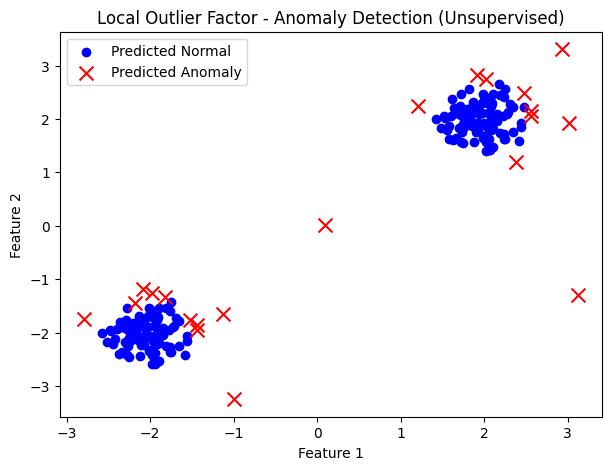

In [19]:
from sklearn.neighbors import LocalOutlierFactor

# Generate synthetic data
rng = np.random.RandomState(42)
X = 0.3 * rng.randn(100, 2)
X = np.r_[X + 2, X - 2]
outliers = rng.uniform(low=-4, high=4, size=(10, 2))
X = np.r_[X, outliers]

# Fit Local Outlier Factor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)

# Plot
plt.figure(figsize=(7,5))
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], c="blue", label="Predicted Normal")
plt.scatter(X[y_pred == -1, 0], X[y_pred == -1, 1], c="red", marker="x", s=100, label="Predicted Anomaly")
plt.title("Local Outlier Factor - Anomaly Detection (Unsupervised)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


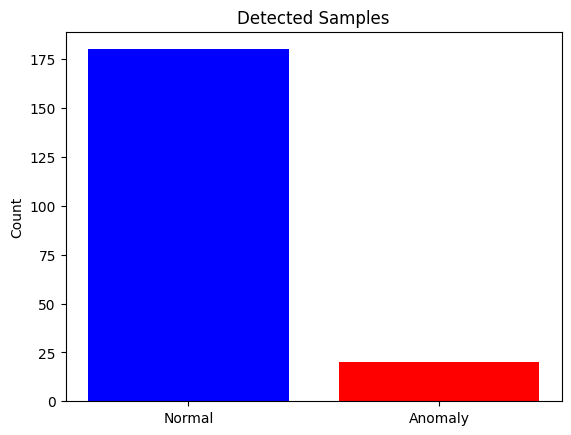

In [20]:
import matplotlib.pyplot as plt

# Example counts
normal_count = 180
anomaly_count = 20

plt.bar(["Normal", "Anomaly"], [normal_count, anomaly_count], color=["blue", "red"])
plt.title("Detected Samples")
plt.ylabel("Count")
plt.show()


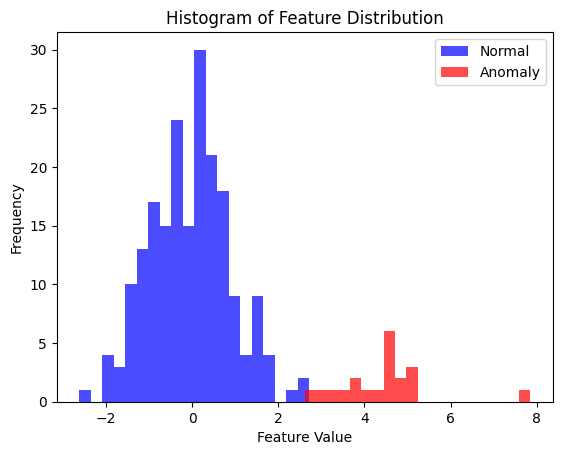

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Example synthetic data
rng = np.random.RandomState(42)
normal = rng.normal(loc=0, scale=1, size=200)
anomalies = rng.normal(loc=4, scale=1, size=20)

plt.hist(normal, bins=20, alpha=0.7, label="Normal", color="blue")
plt.hist(anomalies, bins=20, alpha=0.7, label="Anomaly", color="red")
plt.title("Histogram of Feature Distribution")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()
